## Allstate week w

This week we will learn how to:

* preprocess numeric and categorical features
* tune XGBoost parameters


In [60]:
import xgboost as xgb
import pandas as pd
from sklearn import preprocessing, pipeline, metrics, grid_search, cross_validation
import time
import random
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_absolute_error
%matplotlib inline

## Load Data

In [62]:
# Load data
start = time.time() 
train_data = pd.read_csv('../input/train.csv')
train_size=train_data.shape[0]
print ("Loading train data finished in %0.3fs" % (time.time() - start))        

test_data = pd.read_csv('../input/test.csv')
print ("Loading test data finished in %0.3fs" % (time.time() - start))        

Loading train data finished in 2.568s
Loading test data finished in 4.203s


In [63]:
train_data.head(5)

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,1,A,B,A,B,A,A,A,A,B,...,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18
1,2,A,B,A,A,A,A,A,A,B,...,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60
2,5,A,B,A,A,B,A,A,A,B,...,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09
3,10,B,B,A,B,A,A,A,A,B,...,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,939.85
4,11,A,B,A,B,A,A,A,A,B,...,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,2763.85


## Merge train and test

This will save our time on duplicating logics for train and test and will also ensure the transformations applied on train and test are the same.

In [64]:
full_data=pd.concat((train_data,test_data), ignore_index = True, axis = 0)
del( train_data, test_data)
print ("Full Data set created.")

Full Data set created.


## Group features

In this step we will group the features into different groups so we can preprocess them seperately afterward.

In [65]:
data_types = full_data.dtypes  
cat_cols = list(data_types[data_types=='object'].index)
num_cols = list(data_types[data_types=='int64'].index) + list(data_types[data_types=='float64'].index)

id_col = 'id'
target_col = 'loss'
num_cols.remove('id')
num_cols.remove('loss')

print ("Categorical features:", len(cat_cols))
print ( "Numerica features:", len(num_cols))
print ( "ID: %s, target: %s" %( id_col, target_col))

('Categorical features:', 116)
('Numerica features:', 14)
ID: id, target: loss


## Categorical features 
### 1. Label Encoding (Factorizing) with cat_combs

In [66]:
LBL = preprocessing.LabelEncoder()
start=time.time()
#### 38 selected cat pairs
COMB_FEATURE = [['cat103','cat111'],['cat72','cat103'],['cat80','cat81'],['cat73','cat1'],['cat6','cat103'],['cat80','cat79'],['cat111','cat2'],['cat50','cat111'],['cat9','cat90'],['cat76','cat111'],['cat111','cat13'],['cat79','cat12'],['cat103','cat11'],['cat103','cat4'],['cat111','cat87'],['cat111','cat38'],['cat111','cat36'],['cat25','cat2'],['cat103','cat23'],['cat103','cat10'],['cat111','cat5'],['cat80','cat57'],['cat24','cat103'],['cat7','cat87'],['cat80','cat3'],['cat73','cat40'],['cat85','cat79'],['cat16','cat57'],['cat24','cat28'],['cat46','cat79'],['cat87','cat89'],['cat60','cat73'],['cat9','cat22'],['cat6','cat14'],['cat9','cat47'],['cat9','cat70'],['cat34','cat57'],['cat55','cat57']]
for comb in COMB_FEATURE:
    feat = comb[0] + "_" + comb[1]
    full_data[feat] = full_data[comb[0]] + full_data[comb[1]]
    full_data[feat] = LBL.fit_transform(full_data[feat]).astype(np.uint16)

for cat_col in cat_cols:
#     print ("Factorize feature %s" % (cat))
    full_data[cat_col] = LBL.fit_transform(full_data[cat_col])
print ('Label enconding finished in %f seconds' % (time.time()-start))

Label enconding finished in 48.317741 seconds


### 2. One Hot Encoding (get dummies)

OHE can be done by either Pandas' get_dummies() or SK Learn's OneHotEncoder. 

* get_dummies is easier to implement (can be used directly on raw categorical features, i.e. strings, but it takes longer time and is not memory efficient.

* OneHotEncoder requires the features being converted to numeric, which has already been done by LabelEncoder in previous step, and is much more efficient (7x faster).

* We will convert the OHE's results to a sparse matrix which uses way less memory as compared to dense matrix. However, not all algorithms and packagers support sparse matrix, e.g. Keras. In that case, we'll need to use other tricks to make it work.

In [67]:
cat_cols = [item for i, item in enumerate(full_data.columns.ravel()) if 'cat' in item]
print len(cat_cols)

154


In [68]:
OHE = preprocessing.OneHotEncoder(sparse=True)
start=time.time()
full_data_sparse=OHE.fit_transform(full_data[cat_cols])
print ('One-hot-encoding finished in %f seconds' % (time.time()-start))

print (full_data_sparse.shape)
## it should be (313864, 1176)
# it becomes to (313864, 1911) with cat_comb

One-hot-encoding finished in 19.819749 seconds
(313864, 1911)


### 3. Leave-one-out Encoding

This is a very useful trick that has been used by many Kaggle winning solutions. It's particularly effective for high cardinality categorical features, postal code for instance. However, it doesn't seem to help a lot for this competition and the following code is just FYI. Feel free to skip it as it may take long time to run.

In [ ]:
# start=time.time()
# loo_cols =[]
# for col in cat_cols:
#     print ("Leave-One-Out Encoding  %s" % (col))
#     print ("Leave-one-out encoding column %s for %s......" % (col, target_col))
#     aggr=full_data.groupby(col)[target_col].agg([np.mean]).join(full_data[:train_size].groupby(col)[target_col].agg([np.sum,np.size]),how='left')        
#     meanTagetAggr = np.mean(aggr['mean'].values)
#     aggr=full_data.join(aggr,how='left', on=col)[list(aggr.columns)+[target_col]]
#     loo_col = 'MEAN_BY_'+col+'_'+target_col
#     full_data[loo_col] = \
#     aggr.apply(lambda row: row['mean'] if math.isnan(row[target_col]) 
#                                                        else (row['sum']-row[target_col])/(row['size']-1)*random.uniform(0.95, 1.05) , axis=1)
#     loo_cols.append(loo_col)
#     print ("New feature %s created." % (loo_col))
# print ('Leave-one-out enconding finished in %f seconds' % (time.time()-start))

## Numeric features

We will apply two preprocessings on numeric features:

1. Apply box-cox transformations for skewed numeric features.

2. Scale numeric features so they will fall in the range between 0 and 1.

Please be advised that these preprocessings are not necessary for tree-based models, e.g. XGBoost. However, linear or linear-based models, which will be dicussed in following weeks, may benefit from them.

** Calculate skewness of each numeric features: **

In [69]:
from scipy.stats import skew, boxcox
skewed_cols = full_data[num_cols].apply(lambda x: skew(x.dropna()))
print (skewed_cols.sort_values())

cont2    -0.311146
cont3    -0.007023
cont14    0.250673
cont11    0.281139
cont12    0.291997
cont10    0.352116
cont13    0.376138
cont4     0.417559
cont6     0.458413
cont1     0.513205
cont8     0.673237
cont5     0.679610
cont7     0.825889
cont9     1.067247
dtype: float64


** The purpose of box-cox is to make the skewed data more "normal". Let's have a look at the distributions before and after for feature "cont5": **

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11870bf90>]], dtype=object)

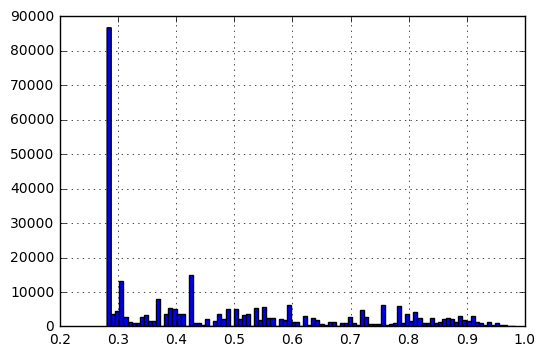

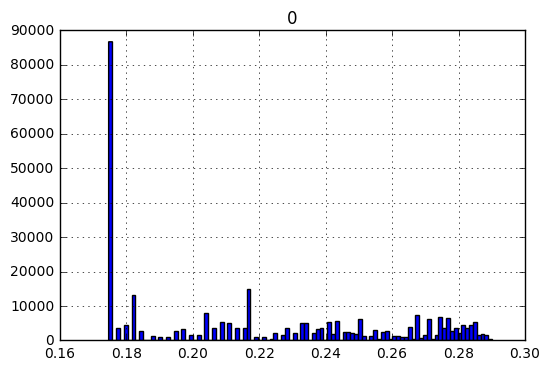

In [26]:
full_data.cont5.hist(color='b', bins=100)
cont5, lam = boxcox(full_data.cont5 + 1)
pd.DataFrame(cont5).hist(color='b', bins=100)

** Apply box-cox transformations: **

In [70]:
skewed_cols = skewed_cols[skewed_cols > 0.25].index.values
for skewed_col in skewed_cols:
    print skewed_col
    full_data[skewed_col], lam = boxcox(full_data[skewed_col] + 1)

cont1
cont10
cont11
cont12
cont13
cont14
cont4
cont5
cont6
cont7
cont8
cont9


** Apply Standard Scaling:**

In [71]:
SSL = preprocessing.StandardScaler()
for num_col in num_cols:
    full_data[num_col] = SSL.fit_transform(full_data[num_col])

/Users/didle/OtherSoftwares/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/didle/OtherSoftwares/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/didle/OtherSoftwares/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape 

#### Note: LBL and OHE are likely exclusive so we will use one of them at a time combined with numeric features. In the following steps we will use OHE + Numeric to tune XGBoost models and you can apply the same process with OHE + Numeric features. Averaging results from two different models will likely generate better results.

In [86]:
# grad - is first derivative of a function and hess is a second derivative of your loss function
# objective = 'reg:linear': minimize MSE, optimizes for the mean
# This problem should minimize MAE, optimizes for the median

# The median for log-normal distribution is exp(u) (log(Loss) ~ N(u, var)) 
# Thus, if you do log transformation on dependent variable and then use MSE to estimate mean of log(Loss) 
# would essentially equal with estimation of median of Loss.
def logregobj(labels, preds):
    con = 2
    x =preds-labels
    grad =con*x / (np.abs(x)+con)
    hess =con**2 / (np.abs(x)+con)**2
    return grad, hess 

def xgb_logregobj(preds, dtrain):
    con = 2
    labels = dtrain.get_label()
    x =preds-labels
    grad =con*x / (np.abs(x)+con)
    hess =con**2 / (np.abs(x)+con)**2
    return grad, hess

def fair_obj(preds, dtrain):
    #fair_constant = 100
    fair_constant = 2
    labels = dtrain.get_label()
    x = (preds - labels)
    den = abs(x) + fair_constant
    grad = fair_constant * x / (den)
    hess = fair_constant * fair_constant / (den * den)
    return grad, hess

# loss function for ln(cosh(x)) objective, where x is absolute error of normally distributed random variable
# convergent slowly
#def logcoshobj(preds, dtrain):
#    labels = dtrain.get_label()
#    grad = np.tanh(preds - labels)
#    hess = 1.0 - grad*grad
#    return grad, hess

# loss function for log(exp(-x) + exp(x)), eqaulivent to the loss function ln(cosh(x))
#def logexpexp(preds, dtrain):
#    labels = dtrain.get_label()
#    x= preds - labels
#    grad = (np.exp(2.0*x) - 1) / (np.exp(2.0*x) + 1)
#    hess = (4.0*np.exp(2.0*x)) / (np.exp(2.0*x) + 1)**2 
#    return grad, hess

# loss function for Cachy function
#cauchyobj <- function(preds, dtrain) {
#  labels <- getinfo(dtrain, "label")
#  c <- 2  #the lower the "slower/smoother" the loss is. Cross-Validate.
#  x <-  preds-labels
#  grad <- x / (x^2/c^2+1)
#  hess <- -c^2*(x^2-c^2)/(x^2+c^2)^2
#  return(list(grad = grad, hess = hess))
#}

lift = 200
def log_mae(labels,preds):
    return mean_absolute_error(np.exp(labels)-lift, np.exp(preds)-lift)

log_mae_scorer = metrics.make_scorer(log_mae, greater_is_better = False)

def xg_eval_mae(yhat, dtrain):
    y = dtrain.get_label()
    return 'mae', mean_absolute_error(np.exp(y)-lift, np.exp(yhat)-lift)

def search_model(train_x, train_y, est, param_grid, n_jobs, cv, refit=False):
##Grid Search for the best model
    model = grid_search.GridSearchCV(estimator  = est,
                                     param_grid = param_grid,
                                     scoring    = log_mae_scorer,
                                     verbose    = 10,
                                     n_jobs  = n_jobs,
                                     iid        = True,
                                     refit    = refit,
                                     cv      = cv)
    # Fit Grid Search Model
    model.fit(train_x, train_y)
    print("Best score: %0.3f" % model.best_score_)
    print("Best parameters set:", model.best_params_)
    print("Scores:", model.grid_scores_)
    return model

In [72]:
from scipy import sparse

full_data_sparse = sparse.hstack((full_data_sparse,full_data[num_cols]), format='csr')
print (full_data_sparse.shape)

train_x = full_data_sparse[:train_size]
test_x = full_data_sparse[train_size:]
train_y = np.log(full_data[:train_size].loss.values + lift)
ID = full_data.id[:train_size].values

xgtrain = xgb.DMatrix(train_x, label=train_y) #used for Bayersian Optimization

from sklearn.cross_validation import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, train_size=.80, random_state=1234)

(313864, 1925)


## XGBoost tuning

### Manual tuning 
1. We will be using holdout data (X_val, y_val) for validation for the sake of time. However, grid search can also be used if time allows.
2. We will start with a larger learning rate (0.1) as it requires less iterations to complete. Once we've got the optimized parameters we can then use a smaller one (0.01 or even smaller) to train the model for better accuracy.

#### 1. Tune max_depth

max_depth is the most important parameter for XGBoost (tree booster) as it controls the complexity of a tree.

Empirically the range is between 5 - 10 but don't let this range limit your explorations. We'll start from 5 and increase it by 1 for next run until MAE won't improve.

In [91]:
#param_grid = {'objective':[logregobj],
#              'learning_rate':[0.1],
#              'n_estimators':[1000],
#              'max_depth': [5, 6, 7, 8, 9, 10, 11, 12],
#              'min_child_weight':[50],
#              'subsample': [0.7],
#             'colsample_bytree':[0.7],
#              'gamma':[0],
#              'nthread': [-1],
#              'seed' : [1234]}

#model = search_model(train_x, train_y, xgb.XGBRegressor(), param_grid, n_jobs = 1, cv = 4, refit = False)
#model.best_score_, model.best_params_, model.grid_scores_

learning_rate = 0.1
for md in range(5, 13):
    rgr = xgb.XGBRegressor( seed = 1234, # use a fixed seed during tuning so we can reproduce the results
                       learning_rate = learning_rate,
                       n_estimators = 10000,
                       max_depth= md,
                       objective = logregobj,
                       nthread = -1,
                       silent = False
                      )
    rgr.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric=xg_eval_mae, early_stopping_rounds=50)
    print '*****'+str(md)+'*****'

Fitting 4 folds for each of 8 candidates, totalling 32 fits
[CV] colsample_bytree=0.7, learning_rate=0.1, nthread=-1, min_child_weight=50, n_estimators=1000, subsample=0.7, seed=1234, objective=<function logregobj at 0x1174c3c80>, max_depth=5, gamma=0 
[CV]  colsample_bytree=0.7, learning_rate=0.1, nthread=-1, min_child_weight=50, n_estimators=1000, subsample=0.7, seed=1234, objective=<function logregobj at 0x1174c3c80>, max_depth=5, gamma=0, score=-1143.941070 - 5.9min
[CV] colsample_bytree=0.7, learning_rate=0.1, nthread=-1, min_child_weight=50, n_estimators=1000, subsample=0.7, seed=1234, objective=<function logregobj at 0x1174c3c80>, max_depth=5, gamma=0 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.9min remaining:    0.0s


[CV]  colsample_bytree=0.7, learning_rate=0.1, nthread=-1, min_child_weight=50, n_estimators=1000, subsample=0.7, seed=1234, objective=<function logregobj at 0x1174c3c80>, max_depth=5, gamma=0, score=-1148.202694 - 6.0min
[CV] colsample_bytree=0.7, learning_rate=0.1, nthread=-1, min_child_weight=50, n_estimators=1000, subsample=0.7, seed=1234, objective=<function logregobj at 0x1174c3c80>, max_depth=5, gamma=0 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 11.9min remaining:    0.0s


[CV]  colsample_bytree=0.7, learning_rate=0.1, nthread=-1, min_child_weight=50, n_estimators=1000, subsample=0.7, seed=1234, objective=<function logregobj at 0x1174c3c80>, max_depth=5, gamma=0, score=-1149.162701 - 6.0min
[CV] colsample_bytree=0.7, learning_rate=0.1, nthread=-1, min_child_weight=50, n_estimators=1000, subsample=0.7, seed=1234, objective=<function logregobj at 0x1174c3c80>, max_depth=5, gamma=0 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 17.9min remaining:    0.0s


[CV]  colsample_bytree=0.7, learning_rate=0.1, nthread=-1, min_child_weight=50, n_estimators=1000, subsample=0.7, seed=1234, objective=<function logregobj at 0x1174c3c80>, max_depth=5, gamma=0, score=-1143.888159 - 6.0min
[CV] colsample_bytree=0.7, learning_rate=0.1, nthread=-1, min_child_weight=50, n_estimators=1000, subsample=0.7, seed=1234, objective=<function logregobj at 0x1174c3c80>, max_depth=6, gamma=0 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 24.0min remaining:    0.0s


[CV]  colsample_bytree=0.7, learning_rate=0.1, nthread=-1, min_child_weight=50, n_estimators=1000, subsample=0.7, seed=1234, objective=<function logregobj at 0x1174c3c80>, max_depth=6, gamma=0, score=-1145.653143 - 6.8min
[CV] colsample_bytree=0.7, learning_rate=0.1, nthread=-1, min_child_weight=50, n_estimators=1000, subsample=0.7, seed=1234, objective=<function logregobj at 0x1174c3c80>, max_depth=6, gamma=0 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 30.8min remaining:    0.0s


[CV]  colsample_bytree=0.7, learning_rate=0.1, nthread=-1, min_child_weight=50, n_estimators=1000, subsample=0.7, seed=1234, objective=<function logregobj at 0x1174c3c80>, max_depth=6, gamma=0, score=-1151.778081 - 6.8min
[CV] colsample_bytree=0.7, learning_rate=0.1, nthread=-1, min_child_weight=50, n_estimators=1000, subsample=0.7, seed=1234, objective=<function logregobj at 0x1174c3c80>, max_depth=6, gamma=0 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 37.6min remaining:    0.0s


[CV]  colsample_bytree=0.7, learning_rate=0.1, nthread=-1, min_child_weight=50, n_estimators=1000, subsample=0.7, seed=1234, objective=<function logregobj at 0x1174c3c80>, max_depth=6, gamma=0, score=-1148.470212 - 6.8min
[CV] colsample_bytree=0.7, learning_rate=0.1, nthread=-1, min_child_weight=50, n_estimators=1000, subsample=0.7, seed=1234, objective=<function logregobj at 0x1174c3c80>, max_depth=6, gamma=0 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 44.4min remaining:    0.0s


[CV]  colsample_bytree=0.7, learning_rate=0.1, nthread=-1, min_child_weight=50, n_estimators=1000, subsample=0.7, seed=1234, objective=<function logregobj at 0x1174c3c80>, max_depth=6, gamma=0, score=-1147.047892 - 6.8min
[CV] colsample_bytree=0.7, learning_rate=0.1, nthread=-1, min_child_weight=50, n_estimators=1000, subsample=0.7, seed=1234, objective=<function logregobj at 0x1174c3c80>, max_depth=7, gamma=0 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 51.2min remaining:    0.0s


[CV]  colsample_bytree=0.7, learning_rate=0.1, nthread=-1, min_child_weight=50, n_estimators=1000, subsample=0.7, seed=1234, objective=<function logregobj at 0x1174c3c80>, max_depth=7, gamma=0, score=-1149.084639 - 7.6min
[CV] colsample_bytree=0.7, learning_rate=0.1, nthread=-1, min_child_weight=50, n_estimators=1000, subsample=0.7, seed=1234, objective=<function logregobj at 0x1174c3c80>, max_depth=7, gamma=0 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 58.8min remaining:    0.0s


[CV]  colsample_bytree=0.7, learning_rate=0.1, nthread=-1, min_child_weight=50, n_estimators=1000, subsample=0.7, seed=1234, objective=<function logregobj at 0x1174c3c80>, max_depth=7, gamma=0, score=-1152.022510 - 7.7min
[CV] colsample_bytree=0.7, learning_rate=0.1, nthread=-1, min_child_weight=50, n_estimators=1000, subsample=0.7, seed=1234, objective=<function logregobj at 0x1174c3c80>, max_depth=7, gamma=0 
[CV]  colsample_bytree=0.7, learning_rate=0.1, nthread=-1, min_child_weight=50, n_estimators=1000, subsample=0.7, seed=1234, objective=<function logregobj at 0x1174c3c80>, max_depth=7, gamma=0, score=-1151.371008 - 7.6min
[CV] colsample_bytree=0.7, learning_rate=0.1, nthread=-1, min_child_weight=50, n_estimators=1000, subsample=0.7, seed=1234, objective=<function logregobj at 0x1174c3c80>, max_depth=7, gamma=0 
[CV]  colsample_bytree=0.7, learning_rate=0.1, nthread=-1, min_child_weight=50, n_estimators=1000, subsample=0.7, seed=1234, objective=<function logregobj at 0x1174c3c80>

[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed: 285.1min finished


In [111]:
max_depth = 6

#### 2. Tune min_child_weight

Similar as max_depth, min_child_weight controls tree complexity only in a different way - the larger the less complex.


I haven't found a sounding range for this parameter though. Therefore I would start with 1 and increase it by 5 each time until until MAE won't improve.

In [82]:
for mc in range(5, 81, 5):
    rgr = xgb.XGBRegressor( seed = 1234, # use a fixed seed during tuning so we can reproduce the results
                       learning_rate = learning_rate,
                       n_estimators = 10000,
                       max_depth= max_depth,
                       min_child_weight=mc,
                       objective = logregobj,
                       nthread = -1,
                       silent = False
                      )
    rgr.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric=xg_eval_mae, early_stopping_rounds=50)
    print '*****'+str(mc)+'*****'


[0]	validation_0-mae:3189.73
Will train until validation_0-mae hasn't improved in 50 rounds.
[1]	validation_0-mae:3078.96
[2]	validation_0-mae:2930.19
[3]	validation_0-mae:2764.69
[4]	validation_0-mae:2595.42
[5]	validation_0-mae:2432.45
[6]	validation_0-mae:2279.82
[7]	validation_0-mae:2138.46
[8]	validation_0-mae:2011.8
[9]	validation_0-mae:1898.57
[10]	validation_0-mae:1799.78
[11]	validation_0-mae:1711.88
[12]	validation_0-mae:1637.36
[13]	validation_0-mae:1573.48
[14]	validation_0-mae:1518.55
[15]	validation_0-mae:1471.39
[16]	validation_0-mae:1431.83
[17]	validation_0-mae:1398.51
[18]	validation_0-mae:1369.55
[19]	validation_0-mae:1344.89
[20]	validation_0-mae:1323.95
[21]	validation_0-mae:1306.81
[22]	validation_0-mae:1292.46
[23]	validation_0-mae:1280
[24]	validation_0-mae:1269.85
[25]	validation_0-mae:1261.46
[26]	validation_0-mae:1254.5
[27]	validation_0-mae:1248.39
[28]	validation_0-mae:1242.93
[29]	validation_0-mae:1238.07
[30]	validation_0-mae:1233.7
[31]	validation_0-mae:

KeyboardInterrupt: 

In [42]:
min_child_weight = 60

#### 3.Tune colsample_bytree

colsample_bytree is the percentage of features that will be used for each tree. 

In my experience the range is between 0.3 - 0.9 so we will start with 0.9 and decrease it by 0.1 each time until MAE won't improve. 



In [43]:
for cb in np.linspace(0.3, 0.9, 7):
    rgr = xgb.XGBRegressor( seed = 1234, # use a fixed seed during tuning so we can reproduce the results
                       learning_rate = learning_rate,
                       n_estimators = 10000,
                       max_depth= max_depth,
                       min_child_weight=min_child_weight, 
                       colsample_bytree=cb,
                       objective = logregobj,
                       nthread = -1,
                       silent = False
                      )
    rgr.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric=xg_eval_mae, early_stopping_rounds=50)
    print '*****'+str(cb)+'*****'
    

[0]	validation_0-mae:3237.09
Will train until validation_0-mae hasn't improved in 50 rounds.
[1]	validation_0-mae:3233.89
[2]	validation_0-mae:3228.52
[3]	validation_0-mae:3220.02
[4]	validation_0-mae:3207.26
[5]	validation_0-mae:3189.09
[6]	validation_0-mae:3164.31
[7]	validation_0-mae:3131.86
[8]	validation_0-mae:3090.93
[9]	validation_0-mae:3040.98
[10]	validation_0-mae:2981.81
[11]	validation_0-mae:2913.55
[12]	validation_0-mae:2836.69
[13]	validation_0-mae:2752.23
[14]	validation_0-mae:2661.28
[15]	validation_0-mae:2565.33
[16]	validation_0-mae:2465.94
[17]	validation_0-mae:2364.58
[18]	validation_0-mae:2263.59
[19]	validation_0-mae:2163.78
[20]	validation_0-mae:2067.39
[21]	validation_0-mae:1975.79
[22]	validation_0-mae:1890.05
[23]	validation_0-mae:1811.01
[24]	validation_0-mae:1738.49
[25]	validation_0-mae:1671.64
[26]	validation_0-mae:1612.37
[27]	validation_0-mae:1560.46
[28]	validation_0-mae:1514.28
[29]	validation_0-mae:1473.19
[30]	validation_0-mae:1437.04
[31]	validation_

In [112]:
colsample_bytree = 0.3

#### 4.Tune subsample

subsample controls the percentage of samples that will be used for each tree. 

The range is likely between 0.6 - 1. We will start with 0.9 and decrease it by 0.1 each time until MAE won't improve.


In [45]:
for ss in np.linspace(0.6, 1, 5):
    rgr = xgb.XGBRegressor( seed = 1234, # use a fixed seed during tuning so we can reproduce the results
                       learning_rate = learning_rate,
                       n_estimators = 10000,
                       max_depth= max_depth,
                       min_child_weight=min_child_weight, 
                       colsample_bytree=colsample_bytree,
                       subsample = ss,
                       objective = logregobj,
                       nthread = -1,
                       silent = False
                      )
    rgr.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric=xg_eval_mae, early_stopping_rounds=50)
    print '*****'+str(ss)+'*****'


[0]	validation_0-mae:3237.09
Will train until validation_0-mae hasn't improved in 50 rounds.
[1]	validation_0-mae:3233.89
[2]	validation_0-mae:3228.51
[3]	validation_0-mae:3220
[4]	validation_0-mae:3207.24
[5]	validation_0-mae:3189.04
[6]	validation_0-mae:3164.22
[7]	validation_0-mae:3131.71
[8]	validation_0-mae:3090.72
[9]	validation_0-mae:3040.69
[10]	validation_0-mae:2981.37
[11]	validation_0-mae:2912.91
[12]	validation_0-mae:2835.98
[13]	validation_0-mae:2751.35
[14]	validation_0-mae:2660.15
[15]	validation_0-mae:2563.84
[16]	validation_0-mae:2464.13
[17]	validation_0-mae:2362.55
[18]	validation_0-mae:2261.13
[19]	validation_0-mae:2161.23
[20]	validation_0-mae:2064.25
[21]	validation_0-mae:1972.15
[22]	validation_0-mae:1886.08
[23]	validation_0-mae:1805.48
[24]	validation_0-mae:1731.46
[25]	validation_0-mae:1665.14
[26]	validation_0-mae:1605.25
[27]	validation_0-mae:1552.17
[28]	validation_0-mae:1505.86
[29]	validation_0-mae:1464.58
[30]	validation_0-mae:1428.03
[31]	validation_0-m

In [46]:
subsample = 0.9

#### 5. Tune gamma

gamma is the minimum loss reduction required to make a further partition on a leaf node of the tree. the larger, the more conservative the algorithm will be.

The range is likely between 0 - 3 We will start with 0.3 and increase it by 0.3 each time until MAE won't improve.


In [49]:
for ga in np.linspace(0, 3, 11):
    rgr = xgb.XGBRegressor( seed = 1234, # use a fixed seed during tuning so we can reproduce the results
                       learning_rate = learning_rate,
                       n_estimators = 10000,
                       max_depth= max_depth,
                       min_child_weight=min_child_weight, 
                       colsample_bytree=colsample_bytree,
                       subsample = subsample,
                       gamma = ga,
                       objective = logregobj,
                       nthread = -1,
                       silent = False
                      )
    rgr.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric=xg_eval_mae, early_stopping_rounds=50)
    print '*****'+str(ga)+'*****'

[0]	validation_0-mae:3237.09
Will train until validation_0-mae hasn't improved in 50 rounds.
[1]	validation_0-mae:3233.89
[2]	validation_0-mae:3228.51
[3]	validation_0-mae:3220
[4]	validation_0-mae:3207.23
[5]	validation_0-mae:3189.02
[6]	validation_0-mae:3164.19
[7]	validation_0-mae:3131.66
[8]	validation_0-mae:3090.61
[9]	validation_0-mae:3040.47
[10]	validation_0-mae:2981.05
[11]	validation_0-mae:2912.61
[12]	validation_0-mae:2835.59
[13]	validation_0-mae:2750.89
[14]	validation_0-mae:2659.76
[15]	validation_0-mae:2563.51
[16]	validation_0-mae:2463.61
[17]	validation_0-mae:2362.21
[18]	validation_0-mae:2260.66
[19]	validation_0-mae:2160.47
[20]	validation_0-mae:2063.76
[21]	validation_0-mae:1971.31
[22]	validation_0-mae:1884.78
[23]	validation_0-mae:1804.36
[24]	validation_0-mae:1730.67
[25]	validation_0-mae:1664.33
[26]	validation_0-mae:1605.5
[27]	validation_0-mae:1552.83
[28]	validation_0-mae:1506.69
[29]	validation_0-mae:1465.6
[30]	validation_0-mae:1429.49
[31]	validation_0-mae

In [50]:
gamma = 0

### Automated tuning - Bayesian Optimization

Github: https://github.com/fmfn/BayesianOptimization

The idea is to set a range for each parameters, for which we can leverage the parameters from manual tuning, then let the bayersian optimization to seek best parameters.

It's more efficient than grid search but is still time consuming. Therefore knowing an approximate range of values for each parameter will greatly improve the performance.

In [115]:
from bayes_opt import BayesianOptimization
def xgb_evaluate(min_child_weight,
                 colsample_bytree,
                 max_depth,
                 subsample,
                 gamma):
    params = dict()
    params['eta'] = 0.1
    params['verbose_eval'] = True
    params['min_child_weight'] = int(min_child_weight)
    params['colsample_bytree'] = max(min(colsample_bytree, 1), 0)
    params['max_depth'] = int(max_depth)
    params['subsample'] = max(min(subsample, 1), 0)
    params['gamma'] = max(gamma, 0)

    cv_result = xgb.cv(params, xgtrain, num_boost_round=10000, nfold=4,obj = xgb_logregobj, feval=xg_eval_mae,
             seed=1234,
             callbacks=[xgb.callback.early_stop(50)])

    return -cv_result['test-mae-mean'].values[-1]


xgb_BO = BayesianOptimization(xgb_evaluate, 
                             {'max_depth': (max_depth - 1, max_depth + 3),
                              'min_child_weight': (min_child_weight - 20, min_child_weight + 20),
                              'colsample_bytree': (max(colsample_bytree - 0.2, 0.1), min(colsample_bytree + 0.2, 1)),
                              'subsample': (max(subsample - 0.2, 0.1), min(subsample + 0.2, 1)),
                              'gamma': (max(gamma - 0.25, 0), gamma + 0.2)
                             }
                            )

xgb_BO.maximize(init_points=5, n_iter=25)

Initialization
---------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   colsample_bytree |     gamma |   max_depth |   min_child_weight |   subsample | 
Multiple eval metrics have been passed: 'test-mae' will be used for early stopping.

Will train until test-mae hasn't improved in 50 rounds.
Stopping. Best iteration:
[1155]	train-mae:1057.63+2.20632	test-mae:1144.83+6.83192

    1 | 22m34s | -1144.83295 |             0.4889 |    0.0223 |      5.4927 |            60.3977 |      0.8613 | 
Multiple eval metrics have been passed: 'test-mae' will be used for early stopping.

Will train until test-mae hasn't improved in 50 rounds.
Stopping. Best iteration:
[933]	train-mae:1038.31+4.83211	test-mae:1146.54+5.59396

    2 | 18m27s | -1146.54364 |             0.4324 |    0.0974 |      6.3529 |            53.8880 |      0.9762 | 
Multiple eval metrics have been passed: 'test-mae' will be used for early stoppin

Show Bayesian Optimized parameters ordered by score

In [116]:
xgb_bo_scores = pd.DataFrame([[s[0]['max_depth'],
                               s[0]['min_child_weight'],
                               s[0]['subsample'],
                               s[0]['colsample_bytree'],
                               s[0]['gamma'],
                               s[1]] for s in zip(xgb_BO.res['all']['params'],xgb_BO.res['all']['values'])],
                            columns = ['max_depth',
                                       'min_child_weight',
                                       'subsample',
                                       'colsample_bytree',
                                       'gamma',
                                       'score'])
xgb_bo_scores=xgb_bo_scores.sort_values('score',ascending=False)
xgb_bo_scores
# Manual: max_depth = 6, min_child_weight = 60, colsample_bytree = 0.3/0.8, subsample = 0.9, gamma = 0, score = 1148.77
# BayesOpt: n_estimators=30190, max_depth = 5, min_child_weight = 80, colsample_bytree = 0.6, subsample = 1.0, gamma = 0.2, score = 1137.58
# BayesOpt: n_estimators=38706, max_depth = 5, min_child_weight = 80, colsample_bytree = 0.1, subsample = 0.7, gamma = 0, score = 1131.446839


,max_depth,min_child_weight,subsample,colsample_bytree,gamma,score
1,5.000000,80.000000,0.700000,0.100000,0.000000,-1141.424561
0,9.000000,40.000000,0.700000,0.100000,0.000000,-1144.741028
2,5.669176,43.097411,0.763380,0.456669,0.109853,-1145.609558
14,7.805533,70.839429,0.937102,0.355791,0.125444,-1146.166840
23,7.805533,70.839429,0.937102,0.355791,0.125444,-1146.166840
22,7.805533,70.839429,0.937102,0.355791,0.125444,-1146.166840
21,7.805533,70.839429,0.937102,0.355791,0.125444,-1146.166840
20,7.805533,70.839429,0.937102,0.355791,0.125444,-1146.166840
19,7.805533,70.839429,0.937102,0.355791,0.125444,-1146.166840
18,7.805533,70.839429,0.937102,0.355791,0.125444,-1146.166840


### Cross validation using parameters from Bayesian Optimization

* This step is to show how the tuned model performs with smaller learning rate (0.01). You'd expect to see more iterations for XGBoost to converage. Therefore, you may want to use a larger number (200 for instance) for early stopping.

* It will also provide optimized iterations (n_rounds/n_estimators).

In [117]:
start = time.time()
params = dict()
params['eta'] = 0.005 ## smaller learning rate yields better accuracy
params['verbose_eval'] = True
params['max_depth'] = int(xgb_bo_scores.head(1).max_depth)
params['min_child_weight'] = int(xgb_bo_scores.head(1).min_child_weight)
params['colsample_bytree'] = float(xgb_bo_scores.head(1).colsample_bytree)
params['subsample'] = float(xgb_bo_scores.head(1).subsample)
params['gamma'] = float(xgb_bo_scores.head(1).gamma)

xgb_cv_result = xgb.cv(params, xgtrain, num_boost_round=500000, nfold=4,obj = xgb_logregobj, feval=xg_eval_mae,
             seed=1234,
             callbacks=[xgb.callback.early_stop(500)])  ## 200 works better for learning rate 0.1 for early stopping

print ("XGB CV finished in %f seconds" % (time.time()-start))
xgb_cv_result.tail(10)

Multiple eval metrics have been passed: 'test-mae' will be used for early stopping.

Will train until test-mae hasn't improved in 500 rounds.
Stopping. Best iteration:
[38705]	train-mae:1048.36+2.0684	test-mae:1131.45+6.49927

XGB CV finished in 33732.191615 seconds


,test-mae-mean,test-mae-std,train-mae-mean,train-mae-std
38696,1131.449920,6.500630,1048.373108,2.072006
38697,1131.449127,6.500391,1048.370636,2.071800
38698,1131.450073,6.499608,1048.369568,2.072223
38699,1131.449981,6.499147,1048.368011,2.071997
38700,1131.448791,6.500082,1048.365326,2.070933
38701,1131.449005,6.499337,1048.364624,2.070799
38702,1131.448181,6.499180,1048.362732,2.069964
38703,1131.448090,6.499690,1048.360596,2.069105
38704,1131.447724,6.498616,1048.359802,2.069550
38705,1131.446839,6.499268,1048.357147,2.068398


## Submission

In [110]:
Repnum = 5
#pred_train_y = np.zeros((train_x.shape[0], Repnum))
pred_test_y = np.zeros((test_x.shape[0], Repnum))

for k in range(Repnum):
    rgr = xgb.XGBRegressor( seed = int(time.time()), 
                       learning_rate = 0.005, ## the smaller learning rate
                       n_estimators = xgb_cv_result.index.max() + 1,
                       max_depth=int(xgb_bo_scores.head(1).max_depth),
                       min_child_weight=int(xgb_bo_scores.head(1).min_child_weight),
                       colsample_bytree=float(xgb_bo_scores.head(1).colsample_bytree),
                       subsample=float(xgb_bo_scores.head(1).subsample),
                       gamma=float(xgb_bo_scores.head(1).gamma),
                       objective = logregobj,
                       nthread = -1,
                       silent = False
                      )
    rgr.fit(train_x, train_y)
    
    #pred_train_y[:, k] = np.exp(rgr.predict(train_x)) - lift
    pred_test_y[:, k] = np.exp(rgr.predict(test_x)) - lift
    #pd.DataFrame({'prob': pred_train_y[:,k]}).to_csv('../output/train_XGBprob_'+str(k)+'.csv', index = False, header = False)
    pd.DataFrame({'prob': pred_test_y[:,k]}).to_csv('../output/test_XGBprob_'+str(k)+'.csv', index = False, header = False)

#results = pd.DataFrame()
#results['id'] = full_data[train_size:].id
#results['loss'] = pred_y
#results.to_csv("../output/sub_xgb_ohe_tuned.csv", index=False)
#print ("Submission created.")

KeyboardInterrupt: 

In [ ]:
pred_train_y = pd.DataFrame(pred_train_y, columns = ['Pred'+str(k) for k in range(Repnum)])
pred_train_y['Pred_mean'] = pred_train_y.mean(axis = 1)
pred_train_y['loss'] = train_y
pred_train_y.to_csv('../output/train_pred.csv', sep = '\t', index = False)

pred_test_y = pd.DataFrame(pred_test_y, columns = ['Pred'+str(k) for k in range(Repnum)])
pred_test_y['Pred_mean'] = pred_test_y.mean(axis = 1)
pred_test_y['id'] = full_data[train_size:].id
pred_test_y.to_csv('../output/test_pred.csv', sep = '\t', index = False)


## Follow up questions

1. Apply the same process to tune another XGBoost model with numeric features + Label Encoded features.
    * Compare MAEs of both models.
    * Average the results of both models as another submission. Is the averaged results perform better? Why?
2. BO seems to be time consuming. Is there any ways to improve the efficiency?
3. Cross validation is used to validate the performance and it takes time. Is there a away to leverage the results to improve models?
3. We've fixed random status to reproduce the results. Can you try training multiple XGBoost models with same parameters and dataset and random seeds, then average the results? Does that help improve the MAE? 